### Projeto Intermediário

O Código a seguir desenvolve o primeiro passo no desenvolvimento do Trabalho de conclusão de curso. O objetivo principal desse trabalho será explorar o mercado de Fundos Imobiliários no Brasil, setor esse que a partir de cálculos preliminares é estimado que representa cerca de 157 bilhões de Reais e mesmo com tamanho volume financeiro direcionado para esse mercado, seu campo acadêmico é pouco desenvolvido e sem grandes dissertações com forte base teórica para embasamento de conclusões. Dessa forma, o presente trabalho visa estudar esse setor e entender quais são os determinantes dos retornos dos FIIs(Fundos de Investimento Imobiliário) no Brasil.

O primeiro e mais importante passo desse trabalho é a exploração dos dados para entender, e qualidade dos dados e a viabilidade do estudo. Dessa forma extraídos todos os dados que serão de relevância durante o trabalho, sendo eles apresentados na seção "Importando os dados".

A seguir no código é feito o tratamento dos dados e início dos cálculos dos principais indicadores que serão utilizados. Além disso, com o uso do índice de negociabilidade é feito um filtro de liquidez com o mesmo critério utilizado pelo IBOVESPA. O índice de negociabilidade tem o objetivo de entender a relevância dos ativos dentro da bolsa, e o IBOVESPA tem como critério ter ao menos a pontuação de 0,1% do volume financeiro da bolsa para ser elegível para o índice. A implementação desse filtro é feita visando eliminar ativos com pouca relevância para o mercado e dessa forma podem ser considerados exceções aos padrões do mercado e dessa forma penalizando a análise.

Os próximos passos a serem tomados é a segmentação dos dados de forma setorial. Essa decisão tem como lógica o fato dos FIIs serem divididos em diferentes setores, sendo os mais comuns os fundos de tijolo, fundos de papel e fiagros, essa segmentação é necessária, pois a estrutura contábil deles muda drasticamente, impossibilitando o uso de alguns indicadores para todos os fundos. Para ilustrar isso pode-se citar o indicador de vacância, que mede a porcentagem ocupada de um imóvel do fundo, no entanto, esse indicador só é disponível para os fundos que alocam um prédio, já para outros como os fundos de papel, que investem em títulos imobiliários esse indicador não estaria disponível, pois eles não são diretamente proprietários de imóveis.

Github: https://github.com/gtvsantos/fiis_project

A líteratura principal literatura do projeto será:<br>
GREEN, Jeremiah; JOHN ; ZHANG, Frank. The Remarkable Multidimensionality in the Cross Section of Expected US Stock Returns. Social Science Research Network, 2013. Disponível em: <https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2262374>.



‌


### Perguntas preliminares

- Os fundos imobiliários geram retornos comparados aos benchmarks(IFIX, IFIL, IBOV, CDI)?
- Modelos clássicos como o CAPM e FamaFrench explicam os retornos dos FIIs?
- Quais retornos estão relacionados aos retornos positivos, há diferenças entre os setores dos FIIs?

### Importando bibliotecas

In [200]:
import pandas as pd
import zipfile
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

### Importando os dados

Foram coletados alguns dados que ajudaram durante o processo, são eles:

- Dados FIIs - https://dados.cvm.gov.br/dataset/fii-doc-inf_mensal<br>
- IPCA - https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=series-historicas<br>
- CDI - https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/serie-historica-do-di.htm <br>
- Indice de negociabilidade - Economática<br>
- Benchmarks - Economatica<br>
- Fechamentos - Economatica<br>
- Características Fiis - CVM e Economática<br>

In [201]:
start_date = 2016
end_date = 2024

diretorio = r"C:\Users\Gustavo Aurelio\Desktop\TCC\clone_repositorio_fii\fiis_project\bases_zip"
base_mensal = pd.DataFrame()

for year in range(start_date, end_date+1):
    zip_mensal = zipfile.ZipFile(diretorio+ f"\Mensal_zip\inf_mensal_fii_{year}.zip")
    # zip_trimestral = zipfile.ZipFile(diretorio + f"\Trimestral_zip\inf_trimestral_fii_{year}.zip")

    bp_inf_mensal = pd.read_csv(zip_mensal.open(f'inf_mensal_fii_ativo_passivo_{year}.csv'), delimiter=";",encoding='latin-1')
    complem_inf_mensal = pd.read_csv(zip_mensal.open(f'inf_mensal_fii_complemento_{year}.csv'), delimiter=";", encoding='latin-1')
    geral_inf_mensal = pd.read_csv(zip_mensal.open(f'inf_mensal_fii_geral_{year}.csv'), delimiter=";", encoding='latin-1')
    base_mensal_year=bp_inf_mensal.merge(complem_inf_mensal,how='outer',on=['Data_Referencia','CNPJ_Fundo','Versao'])
    base_mensal_year=base_mensal_year.merge(geral_inf_mensal,how='outer',on=['Data_Referencia','CNPJ_Fundo','Versao'])

    base_mensal = pd.concat([base_mensal, base_mensal_year], ignore_index=True)

    #Dados trimestrais não foram usados ainda pois precisam da diferenciação dos setores
    # imovel_inf_trimestral = pd.read_csv(zip_trimestral.open(f'inf_trimestral_fii_imovel_{year}.csv'), delimiter=";",encoding='latin-1')
    # result_inf_trimestral = pd.read_csv(zip_trimestral.open(f'inf_trimestral_fii_resultado_contabil_financeiro_{year}.csv'), delimiter=";", encoding='latin-1')

base_mensal['Data_Referencia'] = pd.to_datetime(base_mensal.Data_Referencia)
cdi = pd.read_csv(r'C:\Users\Gustavo Aurelio\Desktop\TCC\bases_gerais\cdi.csv', delimiter=";", header = 38 )
ipca = pd.read_csv(r'C:\Users\Gustavo Aurelio\Desktop\TCC\bases_gerais\ipca.csv', delimiter=";", header = 1 )
ineg = pd.read_csv(r'C:\Users\Gustavo Aurelio\Desktop\TCC\bases_gerais\ineg_fiis.csv', delimiter = ';',header = 3)
benchmarks = pd.read_csv(r'C:\Users\Gustavo Aurelio\Desktop\TCC\bases_gerais\economatica_benchmarks.csv', delimiter=";", header = 3 )
cnpj_ticker = pd.read_excel(r'C:\Users\Gustavo Aurelio\Documents\repositorio\Projeto FIIs\base\CNPJ e TICKER FIIs.xlsx',sheet_name='FIIs',header=6)
fech_nao_ajust = pd.read_csv(r'C:\Users\Gustavo Aurelio\Desktop\TCC\bases_gerais\economatica_fech_nao_ajust.csv',delimiter=';',header=3)
fech_ajust_ed = pd.read_excel(r'C:\Users\Gustavo Aurelio\Desktop\TCC\bases_gerais\economatica_fech_ajust_sem_divid.xlsx',header=3)
fech_divid = pd.read_excel(r'C:\Users\Gustavo Aurelio\Desktop\TCC\bases_gerais\economatica_fech_ajust_com_div.xlsx',header=3)

### Limpando  e ajustando dados

In [202]:

#Serão usados 3 fechamentos diferentes, diferenciando entre os ajustes realizados, os três tipos são:
#1° Fechamento sem ajustes(preço de tela)
#2° Fechamento com ajuste de proventos, mas sem dividendos(replica possíveis ajustes das cotas, por exemplo quando uma ação se transforma em 10(splits))
#3° Fechamento ajustado com proventos e dividendos(esse fechamento será o utilizado no retorno total dos ativos)

#Tratamento dos fechamentos
fech_nao_ajust.columns = fech_nao_ajust.columns.str.replace('Fechamento\nnão aj p/ prov\nEm moeda orig\n','',regex = True)
fech_nao_ajust = fech_nao_ajust.replace({',':'.',
                        '-':np.nan,
                        'Fechamento\nnão aj p/ prov\nEm moeda orig\n':''},regex=True)
fech_nao_ajust['Data'] = pd.to_datetime(fech_nao_ajust.Data,dayfirst=True)

#É feito um merge com uma  coluna de datas para incluir os dados faltantes de feriados, nessas datas de não negociação é colocado o fechamento do ultimo dia negociado
datas_desde_2003 = pd.date_range(start='2003-01-01', end=pd.Timestamp.today(), freq='D')
df_datas = pd.DataFrame({'Data': datas_desde_2003})
fech_nao_ajust = pd.merge(df_datas, fech_nao_ajust, on='Data', how='left')
fech_nao_ajust = fech_nao_ajust.ffill()

fech_nao_ajust = fech_nao_ajust.set_index('Data')
fech_nao_ajust = fech_nao_ajust.apply(pd.to_numeric, errors='ignore').reset_index()
fech_nao_ajust = fech_nao_ajust.ffill() #preencher valores faltantes com ultimo valor disponível, nos casos de final de semana ou feriados terem dados de referência

#Transformação dos dados para formato tidy, para facilitar na manipulação posteriaor dos indicadors
fech_tidy = fech_nao_ajust.melt(id_vars='Data')
fech_tidy.columns = ['Data_Referencia', 'Ticker', 'Fechamento']

#Tratamento do fechamento ajustado exceto dividendos
fech_ajust_ed.columns = fech_ajust_ed.columns.str.replace('Fechamento\najus p/prov ed\nEm moeda orig\n','',regex = True)
fech_ajust_ed = fech_ajust_ed.replace({',':'.',
                        '-':np.nan},regex=True)
fech_ajust_ed['Data'] = pd.to_datetime(fech_ajust_ed.Data,dayfirst=True)
fech_ajust_ed = fech_ajust_ed.set_index('Data')

#Tratamento do fechamento ajustado e com dividendos
fech_divid.columns = fech_divid.columns.str.replace('Fechamento\najust p/ prov\nEm moeda orig\n','',regex = True)
fech_divid = fech_divid.replace({',':'.',
                        '-':np.nan
                        },regex=True)
fech_divid['Data'] = pd.to_datetime(fech_divid.Data,dayfirst=True)
fech_divid = fech_divid.set_index('Data')


#Tratamento dos dados dos dundos mensais
base_mensal['CNPJ_Fundo'] = base_mensal['CNPJ_Fundo'].str.replace('/','',regex=False)
base_mensal['CNPJ_Fundo'] = base_mensal['CNPJ_Fundo'].str.replace('.','',regex=False)
base_mensal['CNPJ_Fundo'] = base_mensal['CNPJ_Fundo'].str.replace('-','',regex=False)

#Pareando CNPJ e Tickers(A base da cvm não coloca os tickers, logo foi necessário pegar os tickers no econoática)
#no entando pelo fato de ter muitos cnpjs sem tickers para parear, acreditamos que os fundos possuem mais de um cnpj
cnpj_ticker = (cnpj_ticker.loc[:,['Ticker','CNPJ/Fundo']].drop_duplicates()).dropna()
cnpj_ticker_dic = dict(zip(cnpj_ticker['CNPJ/Fundo'], cnpj_ticker['Ticker']))
base_mensal['Ticker'] = base_mensal['CNPJ_Fundo'].map(cnpj_ticker_dic)

#Tratamento dados do CDI
cdi = cdi.replace({',':'.',
                    '-':np.nan,
                    'ND':np.nan},regex=True)
cdi['Taxa SELIC'] = pd.to_numeric(cdi['Taxa SELIC'])
cdi['Data'] = pd.to_datetime(cdi.Data, dayfirst=True)
cdi.columns = ['Data', 'tx_selic']

#Tratamento da base de fechamento dos benchmarks
benchmarks.columns = benchmarks.columns.str.replace('Fechamento\najust p/ prov\nEm moeda orig\n','', regex = True)
benchmarks = benchmarks.replace({',':'.',
                        '-':np.nan},regex=True)
benchmarks['Data'] = pd.to_datetime(benchmarks.Data, dayfirst=True)
benchmarks.set_index('Data', inplace = True)
def to_numeric(x):
    return pd.to_numeric(x, errors='coerce')
benchmarks = benchmarks.apply(to_numeric)

#Tratamento da base do Indice de negociabilidade
ineg.columns = ineg.columns.str.replace('Negociabilidade\n1 meses\nEm moeda orig\n','',regex = True)
ineg = ineg.replace({',':'.',
                        '-':np.nan
                        },regex=True)
ineg['Data'] = pd.to_datetime(ineg.Data,dayfirst=True)
ineg = ineg.set_index('Data')

In [203]:
#Calculo do retorno total
retorno_total = fech_divid.pct_change()
retorno_total

,AFHI11,AJFI11,ALZM11,MTOF11,ALZR11,AURB11,ANCR11,FAED11,AROA11,ARXD11,...,TRXF12,TRXB12,VVCO12,VVCR12,VGHF12,EVBI12,LVBI12,RVBI12,VISC12,XPML12
Data,,,,,,,,,,,,,,,,,,,,,
2003-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,0.001632,0.004082,0.010514,NaN,-0.003293,0.000000,0.0,0.005747,-0.008929,-0.009798,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2024-03-12,0.004073,-0.007114,-0.003468,NaN,-0.003812,0.000000,0.0,0.015809,0.009009,0.006421,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2024-03-13,-0.002840,0.004094,0.000000,NaN,0.001616,0.000000,0.0,-0.000188,0.000000,-0.003765,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


### Calculo dos indicadores

In [204]:
indicadores = pd.DataFrame()
#Dados básicos cadastrais
indicadores['CNPJ_Fundo'] = base_mensal['CNPJ_Fundo']
indicadores['Data_Referencia'] = base_mensal['Data_Referencia']
indicadores['Versao'] = base_mensal['Versao']
indicadores['Ticker'] = base_mensal['Ticker']
indicadores = indicadores.merge(fech_tidy,left_on = ['Ticker','Data_Referencia'], right_on = ['Ticker', 'Data_Referencia'], how= 'left')
indicadores['Patrimonio_liquido'] = base_mensal.Patrimonio_Liquido
indicadores['Total_Ativo'] = base_mensal.Valor_Ativo
indicadores['Total_Passivo'] = base_mensal.Total_Passivo
indicadores['Disponibilidades'] = base_mensal.Disponibilidades
indicadores['Rend_distrib'] = base_mensal.Rendimentos_Distribuir
indicadores['n_cotas'] = base_mensal.Cotas_Emitidas

#Valor patrimonial por cota
indicadores['Valor_patri_cotas'] = base_mensal.Valor_Patrimonial_Cotas
#Dividendo por cota
indicadores['Div_p_cota'] = indicadores.Rend_distrib/indicadores.n_cotas
#Valor em caixa/Total de ativos
indicadores['Valor_cx_perc'] = indicadores.Disponibilidades/indicadores.Total_Ativo
#Alavancagem do Fundo
indicadores['Alavancagem'] = indicadores.Total_Passivo/indicadores.Patrimonio_liquido
#Preço/valor patrimonial
indicadores['P_vp'] = indicadores.Fechamento/indicadores.Valor_patri_cotas
#Dividendi yield  por cota mensaç
indicadores['Div_yeld'] = indicadores.Div_p_cota/indicadores.Fechamento
#Dividendos acumulados dos ultimos 12 meses
Dividendos = indicadores[['Data_Referencia','Ticker','Rend_distrib']].set_index('Data_Referencia')
Dividendos = Dividendos.pivot_table(index='Data_Referencia',columns='Ticker',values='Rend_distrib')
Dividendos_12 = Dividendos.rolling(12).sum().reset_index().melt(id_vars='Data_Referencia')
Dividendos_12.columns = ['Data_Referencia', 'Ticker', 'Dividendos_12']
indicadores = indicadores.merge(Dividendos_12,left_on = ['Ticker','Data_Referencia'], right_on = ['Ticker', 'Data_Referencia'], how= 'left')
#Dividendi yield dos ultimos 12 meses
indicadores['Dividend_yield_12'] = (indicadores.Dividendos_12/indicadores.n_cotas)/indicadores.Fechamento

### Estatísticas descritiva
Calcular as estatísticas descritivas para cada fundo imobiliário dos ultimos 3 anos

In [205]:


#selecionar ultimos 3 anos em data_selec
data_selec = fech_divid.index[-1] - pd.DateOffset(years=3)
fech_3anos = fech_divid[fech_divid.index > data_selec].dropna(axis=1, how='all')

def calcular_estatisticas(fundo):
    # Retorno acumulado nos últimos 3 anos
    retorno_acumulado = fech_3anos['AFHI11'].pct_change().add(1).cumprod()[-1] - 1
    # Desvio padrão dos retornos nos últimos 3 anos
    desvio_padrao = fech_3anos[fundo].pct_change().std()
    # Média dos retornos nos últimos 3 anos
    media_retornos = fech_3anos[fundo].pct_change().mean()

    # Retorno do ativo livre de risco
    rf_return = 0
    # Calcular o Sharpe Ratio
    sharpe_ratio = (media_retornos - rf_return) / desvio_padrao
    
    return retorno_acumulado, desvio_padrao, media_retornos, sharpe_ratio
estatisticas_df = pd.DataFrame(index=['Retorno Acumulado', 'Desvio Padrão', 'Média', 'Sharpe Ratio'])

# Calcular estatísticas para cada fundo imobiliário
for coluna in fech_3anos.columns:
    retorno_acumulado, desvio_padrao, media_retornos, sharpe_ratio = calcular_estatisticas(coluna)
    estatisticas_df[coluna] = [retorno_acumulado, desvio_padrao, media_retornos, sharpe_ratio]


estatisticas_df

,AFHI11,AJFI11,ALZM11,ALZR11,AURB11,ANCR11,FAED11,AROA11,ARXD11,ASMT11,...,PVBI12,HSML12,JSAF12,KIVO12,KNHF12,KNHY12,MXRF12,RPRI12,SNEL12,LVBI12
Retorno Acumulado,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,...,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814,0.474814
Desvio Padrão,0.007329,0.008381,0.029791,0.006874,0.026387,0.012826,0.013590,0.146947,0.010515,0.027261,...,0.649934,0.080092,0.093050,0.399682,0.072540,3.149429,0.054908,0.095417,0.116241,0.078540
Média,0.000531,0.000096,0.001451,0.000354,-0.002227,-0.000147,0.000371,0.009498,0.000335,-0.000121,...,0.120690,-0.014563,-0.011809,0.059164,-0.013844,1.247024,-0.005258,-0.016271,-0.024529,-0.012373
Sharpe Ratio,0.072434,0.011467,0.048696,0.051554,-0.084407,-0.011484,0.027335,0.064637,0.031880,-0.004421,...,0.185695,-0.181827,-0.126908,0.148027,-0.190853,0.395952,-0.095767,-0.170522,-0.211018,-0.157534


### Valor de mercado dos FIIs em janeiro de 2024

In [206]:

mkt_cap_fundos = indicadores[(indicadores['Data_Referencia'] == '2024-01-01') & (~indicadores['Ticker'].isnull())]
mkt_cap_fundos = (mkt_cap_fundos.Fechamento * mkt_cap_fundos.n_cotas).sum()

print(str(mkt_cap_fundos.round(2)) + ' de reais é o valor de mercado dos fundos imobiliários')

157169286812.91 de reais é o valor de mercado dos fundos imobiliários


In [207]:
#Calculando retorno total em comparação com alguns benchmarks
comparacao_ = fech_3anos.pct_change().mean(axis=1)
benchmarks_comp = (benchmarks[benchmarks.index > data_selec]).pct_change()
benchmarks_comp['FIIs_equal_weight'] = comparacao_
benchmarks_comp

,IBOV,IBXL,IBXX,IMOB,IFIX,IFIL,FIIs_equal_weight
Data,,,,,,,
2021-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-17,0.022195,0.021111,0.021332,0.032111,-0.002037,-0.002204,-0.001160
2021-03-18,-0.014706,-0.015369,-0.015208,-0.033223,-0.003014,-0.002922,-0.002510
2021-03-19,0.012071,0.009348,0.010039,0.041441,0.003713,0.003171,0.002759
2021-03-22,-0.010693,-0.011596,-0.010703,0.000325,-0.001277,-0.001040,-0.002508
...,...,...,...,...,...,...,...
2024-03-11,-0.007454,-0.008334,-0.007730,-0.000878,-0.002315,-0.002423,0.003842
2024-03-12,0.012244,0.013105,0.012426,0.011794,-0.001686,-0.001912,-0.001087
2024-03-13,0.002649,0.002674,0.002541,0.011039,-0.000392,-0.000329,0.001026


In [208]:
#Calculando do cota do retorno total
cota_total = benchmarks_comp.add(1).cumprod()
cota_total = cota_total[cota_total.index < '2024-01-01']
cota_total

,IBOV,IBXL,IBXX,IMOB,IFIX,IFIL,FIIs_equal_weight
Data,,,,,,,
2021-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-17,1.022195,1.021111,1.021332,1.032111,0.997963,0.997796,0.998840
2021-03-18,1.007162,1.005417,1.005799,0.997821,0.994956,0.994881,0.996332
2021-03-19,1.019320,1.014816,1.015896,1.039171,0.998650,0.998035,0.999082
2021-03-22,1.008420,1.003048,1.005023,1.039509,0.997375,0.996997,0.996576
...,...,...,...,...,...,...,...
2023-12-25,1.164308,1.155908,1.141590,1.081111,1.154987,1.150795,1.193111
2023-12-26,1.171148,1.163035,1.148305,1.086384,1.163818,1.160099,1.198414
2023-12-27,1.176944,1.168593,1.153948,1.093728,1.168494,1.164372,1.201074


### Gráfico comparativo preliminar
Nesse gráfico é possível ver o que teria aconteido caso um investidor tivesse investido nesses ativos desde março de 2021

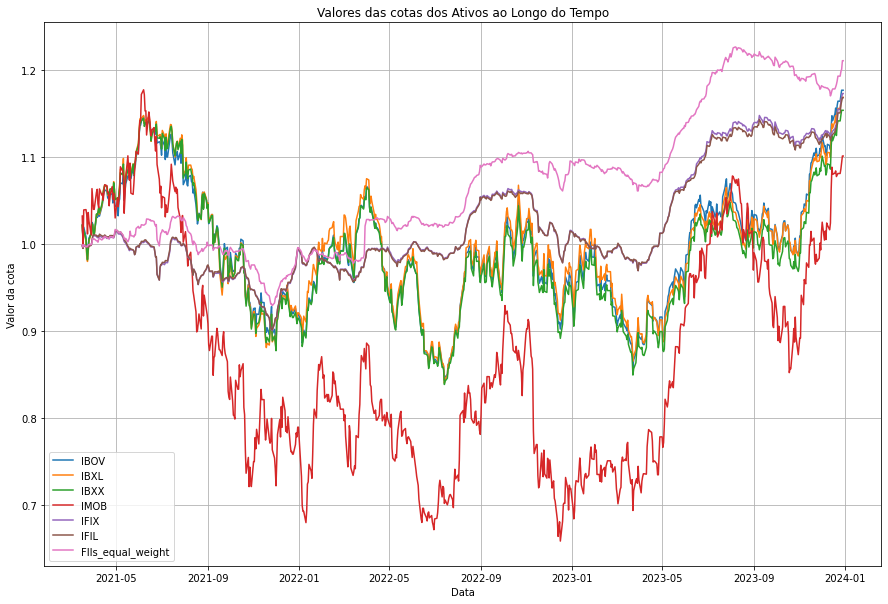

In [209]:
plt.figure(figsize=(15, 10)) 
for coluna in cota_total.columns:
    plt.plot(cota_total.index, cota_total[coluna], label=coluna)
plt.xlabel('Data') 
plt.ylabel('Valor da cota')
plt.title('Valores das cotas dos Ativos ao Longo do Tempo')
plt.legend() 
plt.grid(True)
plt.show() 